# 模型的存储与调用


我们可以使用两种格式将整个模型保存到磁盘：TensorFlow SavedModel 格式和Keras H5格式。以下是TensorFlow对两种模型的官方介绍：

+ SavedModel是更全面的保存格式，它可以保存模型架构、权重和调用函数的跟踪 Tensorflow 子计算图。这使 Keras 能够恢复内置层和自定义对象。TensorFlow Serving（服务器端部署模型）、TensorFlow Lite（移动端部署模型）以及 TensorFlow JS都会用到这一格式的模型文件。 

+ HDF5 文件包含模型的架构、权重值和 compile() 信息。它是 SavedModel 的轻量化替代选择。

## 模型训练与测试


In [2]:
# 导入包
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
# 加载数据
(img_train, label_train), (img_test, label_test) = mnist.load_data()
# 搭建模型
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
# 编译模型
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])
# 训练模型
model.fit(img_train, label_train, batch_size=16, epochs=10,
          validation_data=(img_test,label_test), validation_freq=1)

Epoch 1/10
3750/3750 [==============================] - 9s 2ms/step - loss: 2.2353 - sparse_categorical_accuracy: 0.8513 - val_loss: 0.5703 - val_sparse_categorical_accuracy: 0.8738
Epoch 2/10
3750/3750 [==============================] - 10s 3ms/step - loss: 0.3850 - sparse_categorical_accuracy: 0.9030 - val_loss: 0.3728 - val_sparse_categorical_accuracy: 0.9102
Epoch 3/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.3242 - sparse_categorical_accuracy: 0.9195 - val_loss: 0.3102 - val_sparse_categorical_accuracy: 0.9256
Epoch 4/10
3750/3750 [==============================] - 9s 3ms/step - loss: 0.2954 - sparse_categorical_accuracy: 0.9294 - val_loss: 0.2921 - val_sparse_categorical_accuracy: 0.9386
Epoch 5/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2749 - sparse_categorical_accuracy: 0.9339 - val_loss: 0.3263 - val_sparse_categorical_accuracy: 0.9343
Epoch 6/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.2772 - spa

In [3]:
# 定义模型测试函数
def model_test(model, predict_index):
    """
    可视化测试图片与预测标签。
    model: 输入待测试的模型
    predict_index: 测试集中的测试图片索引，范围0~9999
    输出：None。
    """
    result = model.predict(img_test[predict_index].reshape((1,28,28,1)))
    result_index = np.argmax(result)
    plt.figure()
    plt.imshow(img_test[predict_index], cmap='gray')
    plt.title(f'predict: {result_index}')
    plt.show()

1/1 [==============================] - 0s 182ms/step


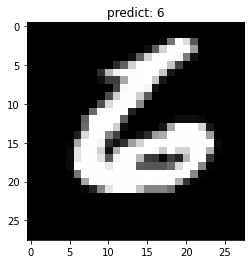

In [4]:
model_test(model, 9999)

## 整体模型保存与加载

### 模型整体保存

我们可以通过`model.save("模型名称")`或者`tf.keras.models.save_model("模型名称")`保存整个模型，这两个函数的输入参数是一致的。

```python
save(
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)
```
+ `filepath`: 字符串。保存的模型文件名称或路径。
+ `overwrite`: 布尔值，默认True。如果有现有同名文件，是否进行重写。
+ `include_optimizer`: 布尔值，默认True。是否保存优化器的状态。
+ `save_format`: 字符串，默认'tf'。'tf'或'h5'格式，代表Tensorflow SavedModel 或者 HDF5 文件。也可以通过将`.h5`作为后缀传入`filepath`保存`h5`格式模型文件。

其他输入参数仅适用于Tensorflow SavedModel格式模型。

#### SavedModel格式

In [5]:
model.save("model")

INFO:tensorflow:Assets written to: model\assets


生成`model`文件夹 ，其中包含2个文件夹和2个文件：
+ `assets`: 空文件夹
+ `variables`: 储存权重
+ `keras_metadata.pb`: 其他配置
+ `saved_model.pb`: 储存模型架构和训练配置（包括优化器、损失和指标）

#### h5格式
生成单个`.h5`文件。

In [6]:
model.save("model.h5")

### 模型整体加载
```python
tf.keras.models.load_model(
    filepath, custom_objects=None, compile=True, options=None
)
```
+ `filepath`: 字符串。保存的模型名称或路径。
+ `custom_objects`: 自定义类或函数的字典映射字典。比如模型中用了自定义的损失函数等。
+ `compile`: 布尔值，默认True。加载模型后是否进行编译。
+ `options`: `tf.saved_model.LoadOptions`对象。

#### SavedModel格式

模型加载

In [7]:
loaded_model_1 = tf.keras.models.load_model('model')

模型使用

1/1 [==============================] - 0s 78ms/step


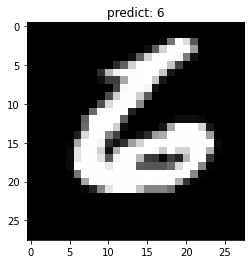

In [8]:
model_test(loaded_model_1, 9999)

#### h5格式

模型加载

In [9]:
loaded_model_2 = tf.keras.models.load_model('model.h5')

模型使用

1/1 [==============================] - 0s 75ms/step


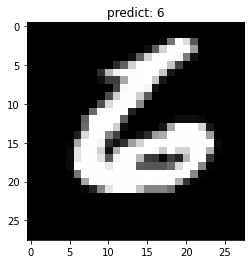

In [10]:
model_test(loaded_model_2, 9999)

## 权重保存与加载
保存整个模型在模型架构复杂的时候可能会占用巨大的内存。比如一个完整的模型可能需要1G的空间，而其中模型参数只占了300MB。所以只保存模型的参数可能会变成一个更好的选择。

### 模型权重保存
```python
save_weights(
    filepath, overwrite=True, save_format=None, options=None
)
```
+ `filepath`: 字符串。保存的模型文件名称或路径。
+ `overwrite`: 布尔值，默认True。如果有现有同名文件，是否进行重写。
+ `save_format`: 字符串，默认'tf'。'tf'或'h5'格式，代表Tensorflow SavedModel 或者 HDF5 文件。也可以通过将`.h5`作为后缀传入`filepath`保存`h5`格式模型文件。

#### SavedModel格式

In [11]:
model.save_weights('weights')

生成3个文件：

+ `checkpoint`
+ `weights.data-00000-of-00001`
+ `weights.index`

#### h5格式
生成单个`.h5`文件。

In [12]:
model.save_weights('weights.h5')

### 模型权重加载
```python
load_weights(
    filepath, by_name=False, skip_mismatch=False, options=None
)
```

+ `filepath`: 字符串。保存的模型名称或路径。
+ `by_name`: 布尔值，默认False。是按名称还是按拓扑顺序加载权重。TensorFlow 格式的权重文件仅支持拓扑加载。
+ `skip_mismatch`: 布尔值，默认False。是否跳过权重数量不匹配或权重形状不匹配的层的加载（仅在by_name=True时有效）
+ `options`: `tf.saved_model.LoadOptions`对象。

#### SavedModel格式

模型加载

In [13]:
# 构建模型结构
loaded_model_3 = tf.keras.models.Sequential()
loaded_model_3.add(tf.keras.layers.Flatten())
loaded_model_3.add(tf.keras.layers.Dense(units=128, activation='relu'))
loaded_model_3.add(tf.keras.layers.Dense(units=10, activation='softmax'))

# 加载权重
loaded_model_3.load_weights('weights')

模型使用

1/1 [==============================] - 0s 123ms/step


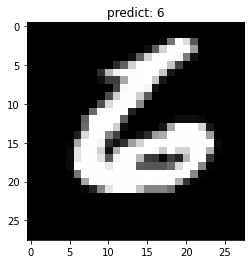

In [14]:
model_test(loaded_model_3, 9999)

#### h5格式

模型加载

In [15]:
# 构建模型结构
loaded_model_4 = tf.keras.models.Sequential()
loaded_model_4.add(tf.keras.layers.Flatten())
loaded_model_4.add(tf.keras.layers.Dense(units=128, activation='relu'))
loaded_model_4.add(tf.keras.layers.Dense(units=10, activation='softmax'))

# 设置模型输入
loaded_model_4.build(input_shape =(None,28,28,1))

# 加载权重
loaded_model_4.load_weights('weights.h5')

模型使用

1/1 [==============================] - 0s 93ms/step


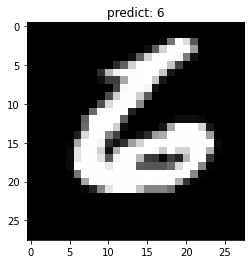

In [16]:
model_test(loaded_model_4, 9999)